In [1]:
import pandas as pd
import numpy as np

## Reading data

`distinct_users_day` contains the information about the visitors and their origin

In [2]:
path="data/distinct_users_day.csv"
dud=pd.read_csv(path,sep=",",encoding="latin-1")
dud=dud[dud['CUST_CLASS']=='visitor'] #keep only visitors
dud=dud[['COD_PRO','VISITORS']].reset_index(drop=True) #keep relevant columns

In [3]:
path="data/codici_istat_provincia.csv"
cod_prov=pd.read_csv(path,sep=",",encoding="latin-1")
cod_prov=cod_prov[['COD_PRO','PROVINCIA']].reset_index(drop=True) #same as before
cod_prov=cod_prov[cod_prov.COD_PRO!=-999]                         #removing others

```bash
cat Veneto.txt | tr ',' '.' > Veneto_fixed.txt
```

We used this bash command to replace commas to points in order to avoid conversion problems

In [4]:
url='https://www.dropbox.com/s/joockt9l4az3euk/Veneto_fixed.txt?dl=1'
distances=pd.read_csv(url,sep=";")
distances=distances[['Origine','Destinazione','Total_Mete']]

In [5]:
path="data/codici_istat_comune.csv"
cod_com=pd.read_csv(path,sep=",",encoding="latin-1")

In the next two blocks we replace the COD_COM with the COD_PRO in the distances matrix.
The problem here is that `codici_istat_comune` does not have all the COMUNI. We avoid this problem by replacing the 
missing COD_COM with the next known COD_COM.

In [6]:
dic={}
for index, row in cod_com.iterrows():
    dic[row.PRO_COM]=row.COD_PRO

def com_to_prov(c):
    try:
        p=dic[c]
    except:
        p=com_to_prov(c+1)
    return p
com_to_prov=np.vectorize(com_to_prov)

In [7]:
origine=distances.Origine.astype(int).values
destinazione=distances.Destinazione.astype(int).values



print(origine[:2])
origine=com_to_prov(origine)
print(origine[:2])

destinazione=com_to_prov(destinazione)

[1042 1042]
[1 1]


In [8]:
cod_Padova=cod_prov[cod_prov.PROVINCIA=='Padova'].COD_PRO.values[0]
distances['Origine']=origine
distances['Destinazione']=destinazione

distances=distances[distances.Destinazione==cod_Padova]
distances=distances.groupby(['Origine','Destinazione'],as_index=False).mean()


In [9]:
dud=dud.groupby(['COD_PRO'],as_index=False).sum()

Same problem as before: some COD_PRO are missing. In this case we just remove the missing COD_PRO.

In [10]:
dic={}
for index, row in distances.iterrows():
    dic[row.Origine]=row.Total_Mete

def prov_to_dist(p):
    try: 
        d=dic[p]
    except:
        d=-1
    return d 
prov_to_dist=np.vectorize(prov_to_dist)

In [11]:
dud['DISTANCES']=prov_to_dist(dud.COD_PRO.astype(int))
print(np.sum(dud.VISITORS[dud.DISTANCES==-1]))
dud=dud[dud.DISTANCES!=-1]

35980


### Make the distribution

In [12]:
def distribution(N,df):
    dist=df.DISTANCES.values
    freq=df.VISITORS.values

    bins=np.linspace(np.min(dist),np.max(dist),N+1)

    f_bins=[]
    for i in range(len(bins)-1):
        f=np.sum(freq[dist<=bins[i+1]])
        f-=np.sum(freq[dist<bins[i]])
        f_bins.append(f)

    bins=(bins[1:]+bins[:-1])*0.5

    return bins, f_bins

nbins=120

bins, f_bins = distribution(nbins,dud)

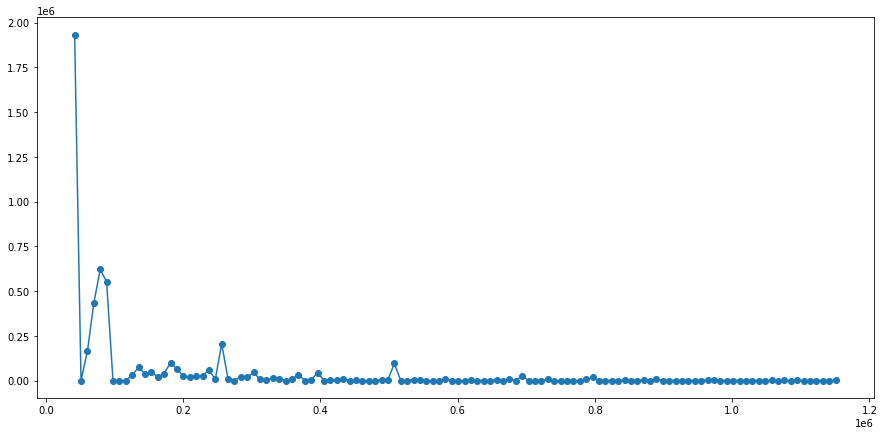

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))
plt.plot(bins,f_bins,'-o')

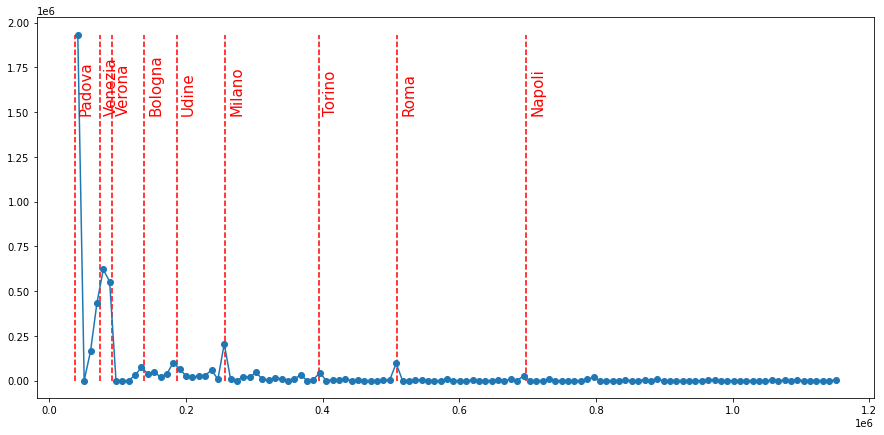

In [14]:
big=['Milano','Venezia','Roma','Napoli','Bologna','Torino','Udine','Verona','Padova']
cod_big=[]
for i in big:
    cod_big.append(cod_prov[cod_prov.PROVINCIA==i].COD_PRO.values[0])



plt.figure(figsize=(15,7))
plt.plot(bins,f_bins,'-o')

for i in range(len(big)):
    plt.vlines(prov_to_dist(cod_big[i]),min(f_bins),max(f_bins),color='r',linestyles='dashed')
    plt.text(prov_to_dist(cod_big[i])+6e3,1.5E6,big[i],fontsize=15,color='r',rotation=90)


In [19]:
dud=dud[dud.COD_PRO!=28] #REMOVING PADOVA

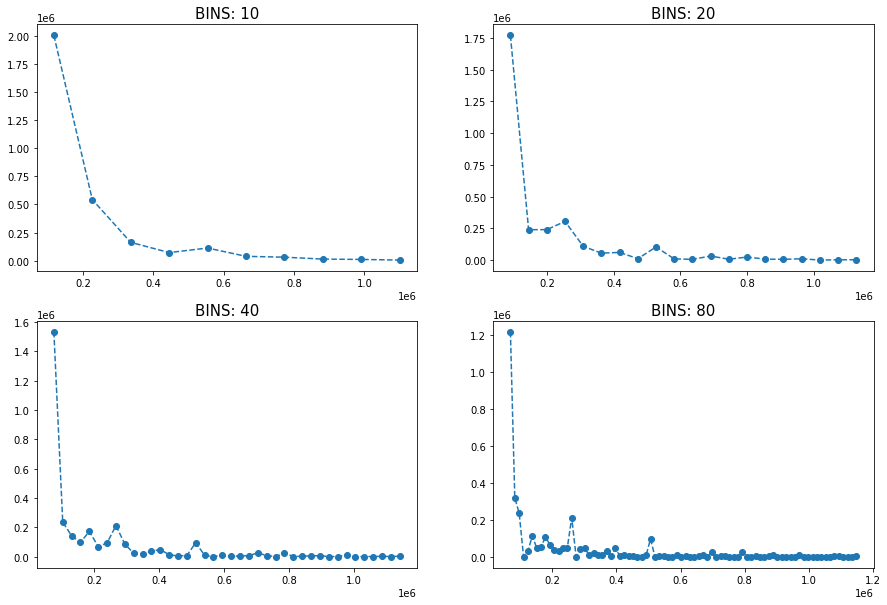

In [20]:
f, AX = plt.subplots(2,2,figsize=(15,10))
nbins=10
for ax in AX.flatten():
    bins, f_bins = distribution(nbins,dud)

    ax.plot(bins,f_bins,'--o')
    ax.set_title('BINS: '+str(nbins),fontsize=15)
    nbins*=2

If we consider a population equally distributed on the terrirory, we can hypothesize an exponential 
trend in how much the persons more near to Padua are more propensity to visit the city. 
The problem is that the population is more concentrated into the main city and so we 
observe peaks in correspondence of the main cities as we can see in plots with `nbins>10`. To avoid this fluctuations 
we try to do the regression using a small number of bins.

[ 0.02768303 -0.02543816]


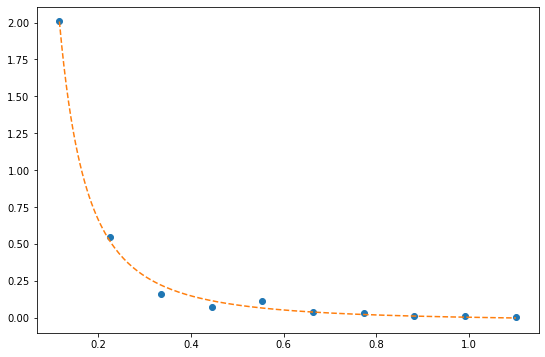

In [66]:
from scipy import optimize
def f(x,A,B):
    return A/x**2+B

nbins=10
bins, f_bins = distribution(nbins,dud)
bins, f_bins = distribution(nbins,dud)
bins/=1e6
f_bins=np.array(f_bins)/1e6

max_params, params_covariance = optimize.curve_fit(f, bins, f_bins, p0=[1e6, 1e5])


x=np.linspace(np.min(bins),np.max(bins),200)
plt.figure(figsize=(9,6))
plt.plot(bins,f_bins,'o')
plt.plot(x,f(x,max_params[0],max_params[1]),'--')
print(max_params)